In [2]:
import pandas
import os
import sys
import plotly
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from scipy import stats
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error
sys.path.insert(0,'/Users/jacobv/git/data_driven_pathology/')
import CrossDecomp as XD

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
%matplotlib inline

# Prepare Data

In [4]:
# Where to save figures
fig_dir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/'

In [5]:
bigdf = pandas.read_csv('data/expression.csv')

In [6]:
bigdf.shape

(3466, 15634)

In [7]:
ls /Users/jacobv/abagen-data/microarray/normalized_microarray_donor10021/

MicroarrayExpression.csv  PACall.csv                Readme.txt
Ontology.csv              Probes.csv                SampleAnnot.csv


In [8]:
#wdir = '/Users/jacobv/Science/PLS_GXP/txfer/'
allendir = '/Users/jacobv/abagen-data/microarray/'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
gdf = pandas.read_csv('data/gxp_correlation_wholebrain_results_NEW.csv',index_col=0)

In [9]:
gdf.loc[:,'ind'] = gdf.index.values
gdf.index = gdf.well_id.values
gdf = gdf.loc[bigdf.well_id.values]
gdf.index = gdf.ind.values

In [11]:
gdf.to_csv('data/meta.csv')

In [63]:
all(gdf.well_id.values == bigdf.well_id.values)

True

In [8]:
# cols = ['Unnamed: 0', 'donor', 'sample', 'structure_id', 'slab_num', 'well_id',
#        'slab_type', 'structure_acronym', 'structure_name', 'polygon_id',
#        'mri_voxel_x', 'mri_voxel_y', 'mri_voxel_z', 'mni_x', 'mni_y', 'mni_z',
#        'mni_nlin_x','mni_nlin_y', 'mni_nlin_z']
# all_inputs = {'expression':bigdf, 'samples':gdf[cols], 'probes':probes}
# pandas.to_pickle(all_inputs,
#                  '/Users/jacobv/Science/PLS_GXP/txfer/allcorr_inputs.pk')

In [64]:
#bigdf.index = bigdf.well_id
bigdf.index = gdf.index
bigdf.drop('well_id',axis=1,inplace=True)


In [65]:
too_few = [x for x in gdf.structure_acronym.value_counts().index if gdf.structure_acronym.value_counts()[x] < 2]
gdf.loc[:,'new_structure_acronym'] = ['Other' if x in too_few else x for x in gdf.structure_acronym.values]

In [66]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)

0.8460579522910678

In [67]:
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf),index = gdf.index)

In [37]:
# delete?
#pca_tfm.to_csv('~/Downloads/pca_matrix_Allen.csv')

In [41]:
## delete?
# gdf.loc[:,'abs_mni_nlin_x'] = abs(gdf.mni_nlin_x.values)
# gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x','slab_type']
#    ].to_csv('~/Downloads/spatial_location.csv')

In [68]:
gdf.loc[:,'abs_mni_nlin_x'] = abs(gdf.mni_nlin_x.values)
tr,te = train_test_split(pca_tfm, stratify=gdf.new_structure_acronym.values, random_state=123)
tr_y = gdf.loc[tr.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]

In [71]:
len(gdf.structure_acronym.unique())

212

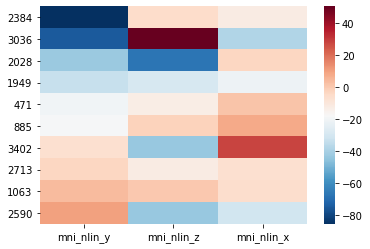

In [26]:
jnk = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z','mni_nlin_x']]
sns.heatmap(jnk.loc[np.random.choice(jnk.index,10)].sort_values('mni_nlin_y'),
           cmap='RdBu_r')
plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/XYZ_heatmap.pdf',
           bbox_inches='tight')

# Train model

#### Cross-validation w/ repeated cv for CIs

In [127]:
from sklearn.cross_decomposition import PLSCanonical, PLSSVD
from sklearn.model_selection import KFold

ncs = 3
nc_chooser = pandas.DataFrame(index = range(ncs*3), columns = ['nc', 'estimator', 'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), 
                  'CCA': CCA(n_components=nc),
                 'PLSC': PLSCanonical(n_components=nc)}
#    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        for it in range(10):
            cv=KFold(10,shuffle=True,random_state=123+it)
            pred = cross_val_predict(estimator, tr, tr_y, 
                                    groups = gdf.loc[tr.index].slab_type, 
                                     cv=cv)
            nc_chooser.loc[i, 'r2'] = r2_score(y_true=tr_y, y_pred=pred)
            nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=tr_y, y_pred=pred)
            nc_chooser.loc[i, 'estimator'] = lab
            nc_chooser.loc[i,'nc'] = nc
            nc_chooser.loc[i,'iter'] = it
            i+=1

1
2
3


In [39]:
nc_chooser

,nc,estimator,r2,mae,iter
0,1,PLSR,0.346599,16.928226,0.0
1,1,PLSR,0.34633,16.914165,1.0
2,1,PLSR,0.346139,16.921233,2.0
3,1,PLSR,0.346413,16.903514,3.0
4,1,PLSR,0.34671,16.891774,4.0
...,...,...,...,...,...
85,3,PLSC,0.643427,12.206621,5.0
86,3,PLSC,0.64465,12.157278,6.0
87,3,PLSC,0.645913,12.142304,7.0
88,3,PLSC,0.642444,12.221011,8.0


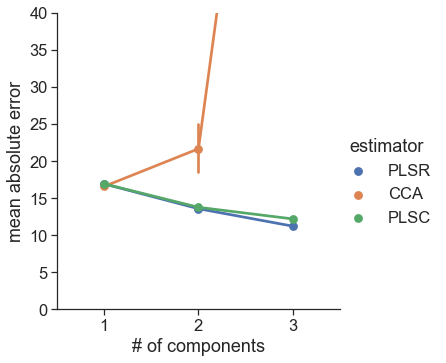

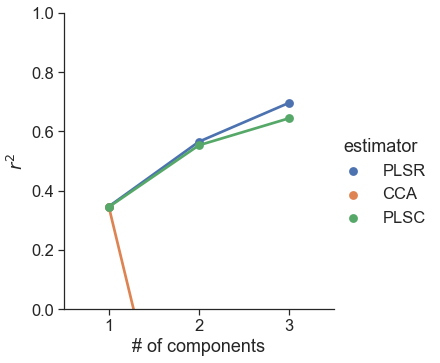

In [129]:
sns.set(font_scale=1.5)
sns.set_style('ticks')

sns.catplot(x = 'nc', y='mae', hue = 'estimator', 
               data=nc_chooser,aspect=1,kind='point')
plt.ylabel('mean absolute error')
plt.xlabel('# of components')
plt.savefig(os.path.join(fig_dir,'estimator_selection_cv_mae_rkf.pdf'), bbox_inches='tight')
plt.ylim(0,40)
plt.show()

sns.catplot(x = 'nc', y='r2', hue = 'estimator', 
               data=nc_chooser,#[nc_chooser.nc<5],
               aspect=1,kind='point')
plt.ylabel('$r^{2}$')
plt.xlabel('# of components')
plt.ylim(0,1)
plt.savefig(os.path.join(fig_dir,'estimator_selection_cv_r2_rkf.pdf'), bbox_inches='tight')
plt.show()

#### Cross-validation w/ bootstrapping for CIs

In [130]:
from sklearn.cross_decomposition import PLSCanonical, PLSSVD
from sklearn.model_selection import KFold

ncs = 3
nc_chooser = pandas.DataFrame(index = range(ncs*3), 
                              columns = ['nc', 'estimator', 
                                         'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), 
                  'CCA': CCA(n_components=nc),
                 'PLSC': PLSCanonical(n_components=nc)}
#    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        for it in range(100):
            nind = np.random.choice(tr.index,len(tr.index))
            pred = cross_val_predict(estimator, tr.loc[nind],
                                     tr_y.loc[nind],
                                    groups = gdf.loc[nind].slab_type, 
                                     cv=10)
            nc_chooser.loc[i, 'r2'] = r2_score(y_true=tr_y.loc[nind],
                                               y_pred=pred)
            nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=tr_y.loc[nind],
                                                           y_pred=pred)
            nc_chooser.loc[i, 'estimator'] = lab
            nc_chooser.loc[i,'nc'] = nc
            nc_chooser.loc[i,'iter'] = it
            i+=1

1
2
3


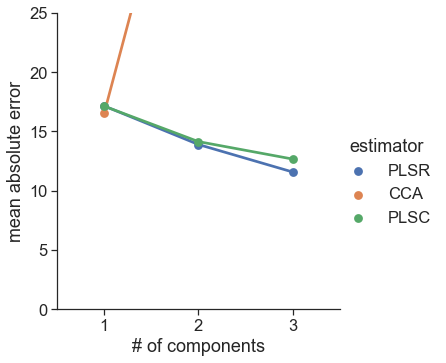

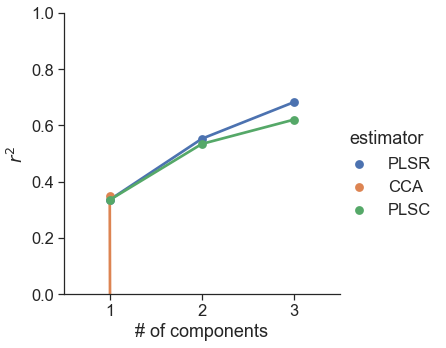

In [133]:
sns.set(font_scale=1.5)
sns.set_style('ticks')

sns.catplot(x = 'nc', y='mae', hue = 'estimator', 
               data=nc_chooser,aspect=1,kind='point')
plt.ylabel('mean absolute error')
plt.xlabel('# of components')
plt.ylim(0,25)
plt.savefig(os.path.join(fig_dir,'estimator_selection_cv_mae_bs_100.pdf'), bbox_inches='tight')
plt.show()

sns.catplot(x = 'nc', y='r2', hue = 'estimator', 
               data=nc_chooser,#[nc_chooser.nc<5],
               aspect=1,kind='point')
plt.ylabel('$r^{2}$')
plt.xlabel('# of components')
plt.ylim(0,1)
plt.savefig(os.path.join(fig_dir,'estimator_selection_cv_r2_bs_100.pdf'), bbox_inches='tight')
plt.show()

In [134]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)

PLSRegression(n_components=3)

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


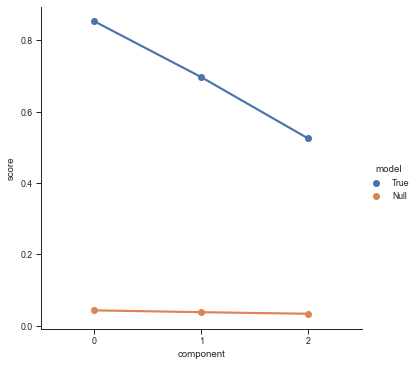

component 0: p = 0.001  ***
component 1: p = 0.001  ***
component 2: p = 0.001  ***


In [135]:
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y, n_iterations=1000)

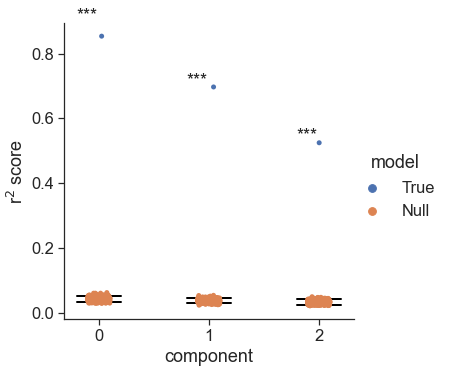

In [136]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
sns.catplot(x='component', y='score', hue='model', data=results)
plt.text(-0.20,0.9,'***')
plt.text(0.80,0.7,'***')
plt.text(1.80,0.53,'***')
plt.ylabel('r$^2$ score')
for c in range(len(results.component.unique())):
    cvals = results[(results.model=='Null')&(results.component==c)
                ].score.sort_values().values
    cmin = cvals[25]
    cmax = cvals[975]
    plt.plot([c-.2,c+.2],[cmin,cmin],lw=2,c='black')
    plt.plot([c-.2,c+.2],[cmax,cmax],lw=2,c='black')
plt.savefig(os.path.join(fig_dir,'sig_componentsTR.pdf'), bbox_inches='tight')

# Evaluate model

In [28]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)

PLSRegression(n_components=3)

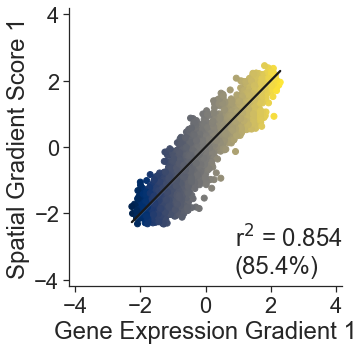

r2 = 0.8536305903100613, percent of total = 0.8536305903100613


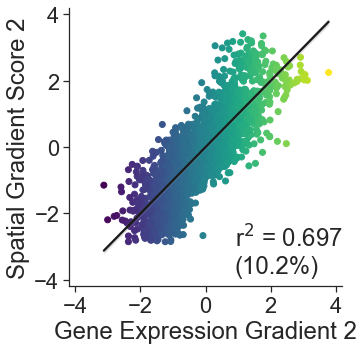

r2 = 0.6969288711885936, percent of total = 0.10200906747174979


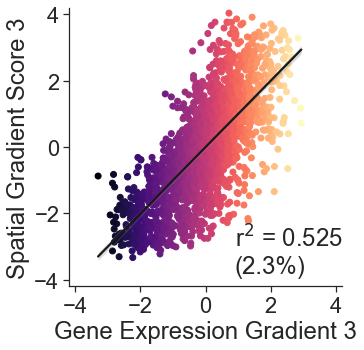

r2 = 0.5247844536368539, percent of total = 0.023279617954116143


In [140]:
# plot component scores
sns.set_context('notebook',font_scale=2)
total = 1
leftover = 1
pals = ['cividis','viridis','magma']
for i in range(pls_mod.n_components):
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = (leftover * r2)
    exp_perc = explained * 100
    plt.close()
    plotr = pandas.concat([pandas.Series(pls_mod.x_scores_[:,i]),
                          pandas.Series(pls_mod.y_scores_[:,i])],
                         axis=1)
    plotr.columns = ['x','y']
    # colors
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = pls_mod.x_scores_[:,i]
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                   vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))
    
    g=sns.lmplot(x='x', y='y',data=plotr,scatter_kws={'color':cscale},line_kws={'color':'k'})
    plt.xlim(-4.2,4.2)
    plt.ylim(-4.2,4.2)
    g.set(xticks=[-4,-2,0,2,4])
    plt.xlabel('Gene Expression Gradient %i'%(i+1))
    plt.ylabel('Spatial Gradient Score %i'%(i+1))
    plt.text(.9,-3.8,'r$^2$ = %s \n(%s%%)'%(round(r2,3),round(exp_perc,1)))
    plt.savefig(os.path.join(fig_dir,'principal_correlation_%s.pdf'%i),bbox_inches='tight')
    plt.show()
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover -= explained


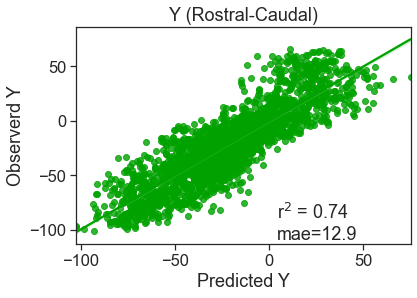

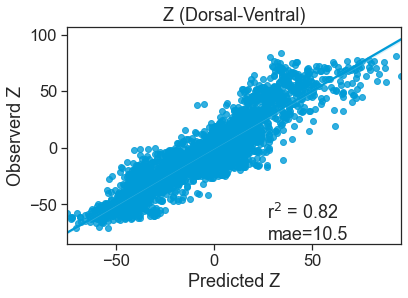

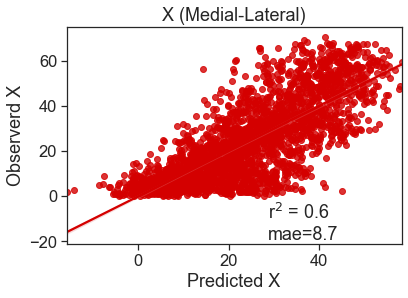

In [163]:
# plot model fit
pal=sns.color_palette('nipy_spectral',n_colors=12)
colos = dict(zip(['Y','Z','X'],
                [pal[5],pal[3],pal[-1]]
                ))

pred = pls_mod.predict(tr)
labs = dict(zip(['Y','Z','X'],
                ['Rostral-Caudal',
                  'Dorsal-Ventral',
                  'Medial-Lateral']))

for i in range(tr_y.shape[-1]):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    label = tr_y.columns[i][-1].upper()
    sns.regplot(x=pred[:,i], y=tr_y[tr_y.columns[i]],
                color = colos[label]
               )
    plt.title('%s (%s)'%(label,labs[label]))
    plt.xlabel('Predicted %s'%label)
    plt.ylabel('Observerd %s'%label)
    
#     tx = np.max(pred[:,i]) - np.min(pred[:,i]) * .4
#     tx = np.min(pred[:,i]) + tx
#     ty = np.max(tr_y[tr_y.columns[i]]
#                ) -np.min(tr_y[tr_y.columns[i]]) * -.5
#     ty = np.min(tr_y[tr_y.columns[i]]) + ty
    r2 = stats.pearsonr(pred[:,i], tr_y[tr_y.columns[i]])[0]**2
    mae = mean_absolute_error(pred[:,i], tr_y[tr_y.columns[i]])
    plt.text(0.6,0.02,
             'r$^2$ = %s \nmae=%s'%(round(r2,2),round(mae,1)),
            transform=ax.transAxes)
#     plt.savefig(os.path.join('TestRes_%s.pdf'%label),bbox_inches='tight')
    plt.show()


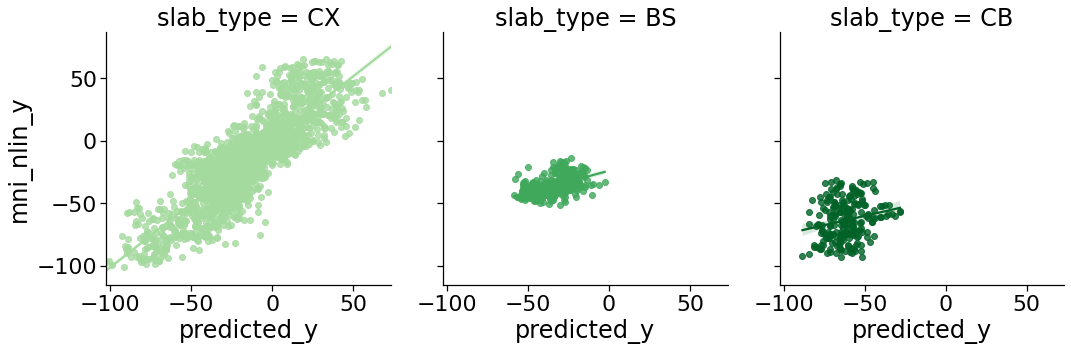

CX r2 =0.7147103895041135
CX mae =13.731615251655338
BS r2 =0.261800805927325
BS mae =7.334921285601586
CB r2 =0.04477004819290093
CB mae =14.735364564585389


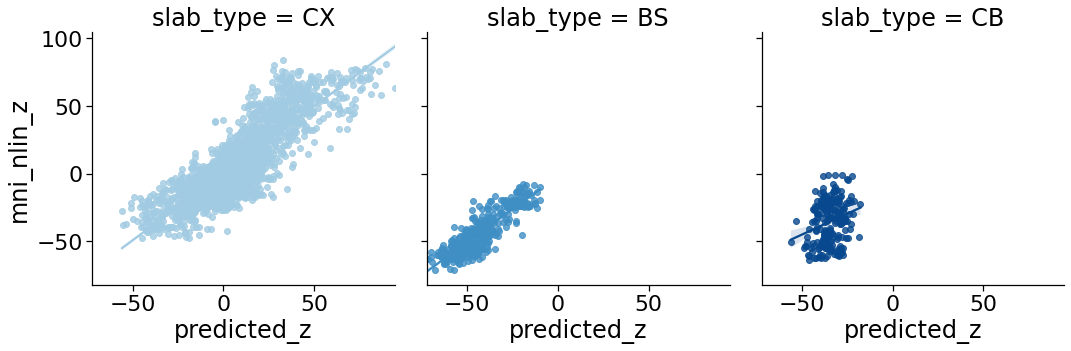

CX r2 =0.7250150957299403
CX mae =11.064288544979279
BS r2 =0.7405010678602725
BS mae =6.494937600605593
CB r2 =0.06244208758350392
CB mae =13.365140956067277


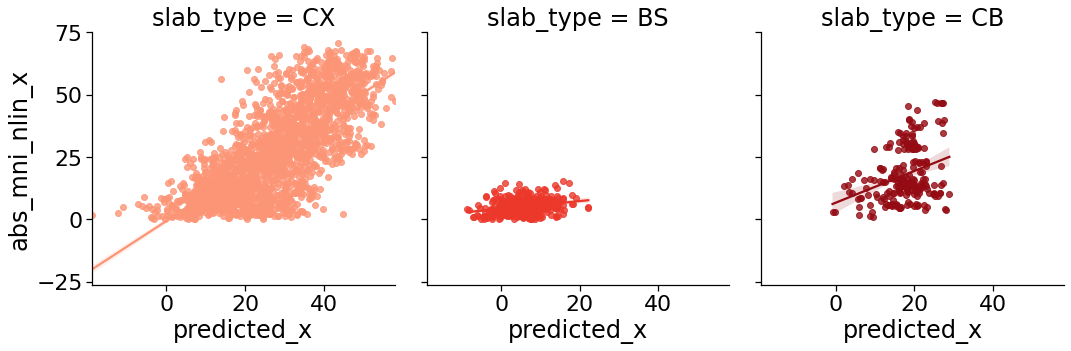

CX r2 =0.5256713738152855
CX mae =9.661237673606301
BS r2 =0.07425880793357378
BS mae =4.269763938819749
CB r2 =0.1064383031649988
CB mae =8.80699919567299


In [38]:
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(pred, index=tr_y.index), tr_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z','predicted_x'] + tr_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[tr.index,'slab_type']
n_components = tr_y.shape[-1]
regpals = ['Greens','Blues','Reds']
for i in range(n_components):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+n_components], 
               col = 'slab_type', data = preds_df,hue='slab_type',
               palette = list(np.array(sns.color_palette(regpals[i],10))[[3,6,9]])
               #palette=list(colos.values())
              )
    #plt.title(preds_df.columns[i+n_components])
    plt.show()
    for slab in preds_df.slab_type.unique():
        if not pandas.notnull(slab):
            continue
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+n_components]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i+n_components]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

# Test model

In [142]:
pal=sns.color_palette('nipy_spectral',n_colors=12)
colos = dict(zip(['Y','Z','X'],
                [pal[5],pal[3],pal[-1]]
                ))
pal

[(0.4993470588235294, 0.0, 0.5659960784313726),
 (0.0, 0.0, 0.6784647058823529),
 (0.0, 0.2928313725490196, 0.8667),
 (0.0, 0.6078470588235294, 0.8431705882352941),
 (0.0, 0.6667, 0.575150980392157),
 (0.0, 0.633978431372549, 0.0),
 (0.0, 0.8326960784313726, 0.0),
 (0.2300549019607843, 1.0, 0.0),
 (0.9097705882352941, 0.9411470588235294, 0.0),
 (1.0, 0.7254901960784318, 0.0),
 (1.0, 0.03529411764705881, 0.0),
 (0.8326960784313726, 0.0, 0.0)]

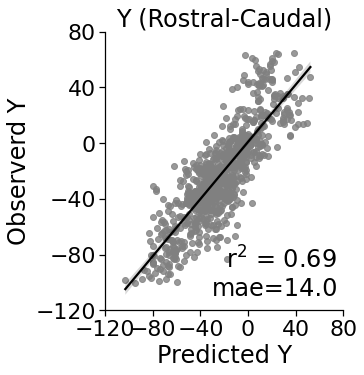

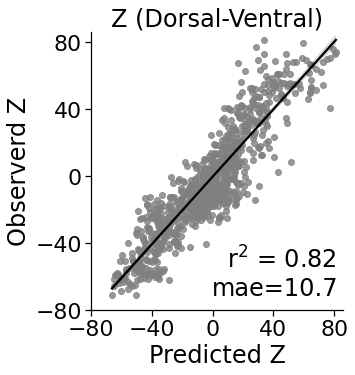

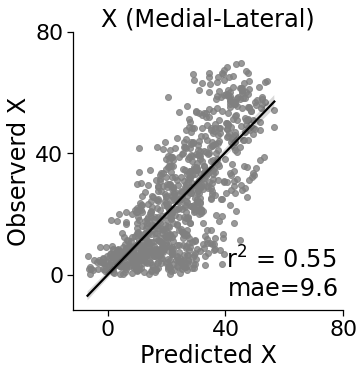

In [35]:
sns.set_context('notebook',font_scale=2)
# plot model fit
dims = ['Y','Z','X']
labs = dict(zip(dims,['Rostral-Caudal',
                      'Dorsal-Ventral',
                      'Medial-Lateral']))
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
#     fig = plt.figure(figsize=(6,4))
#     ax = fig.add_subplot(111)
    label = te_y.columns[i][-1].upper()
    plotr = pandas.concat([pandas.Series(te_pred[:,i]),
                          pandas.Series(te_y[te_y.columns[i]].values)],
                         axis=1)
    plotr.columns = ['x','y']
    g=sns.lmplot(x='x', y='y',data=plotr,
                 scatter_kws={'color':'gray', 'alpha':0.8},#colos[label]},
                 line_kws={'color':'k'}
                )
    pmax = np.max(plotr.max().values)
    pmin = np.min(plotr.min().values)
    incr = 40
    tmin = int(round((pmin/incr))*incr)
    tmax = int(round((pmax/incr))*incr) + 1
    trange = list(range(tmin,tmax,incr))
    plt.title('%s (%s)'%(label,labs[label]))
    plt.xlabel('Predicted %s'%label)
    plt.ylabel('Observerd %s'%label)
    plt.xlim(pmin-5,pmax+5)
    plt.ylim(pmin-5,pmax+5)
    g.set(xticks=trange,yticks=trange)
    r2 = stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]])[0]**2
    mae = mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]])
    plt.text(0.85,0.2,
             'r$^2$ = %s \nmae=%s'%(round(r2,2),round(mae,1)),
            transform=ax.transAxes,horizontalalignment='right')
    plt.savefig(os.path.join(fig_dir,'TestRes_%s_gray.pdf'%label),bbox_inches='tight')
    plt.show()


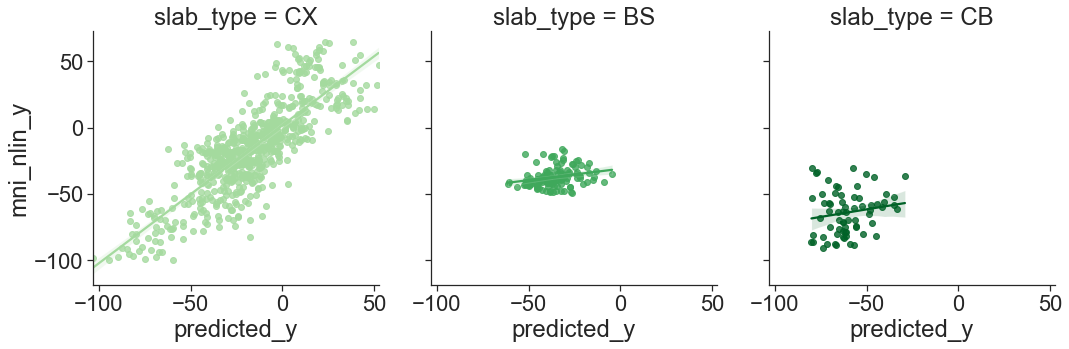

CX r2 =0.670495114117763
CX mae =14.705616290906303
BS r2 =0.06232205475443241
BS mae =9.132789166407923
CB r2 =0.02859952657360278
CB mae =15.970188816891092


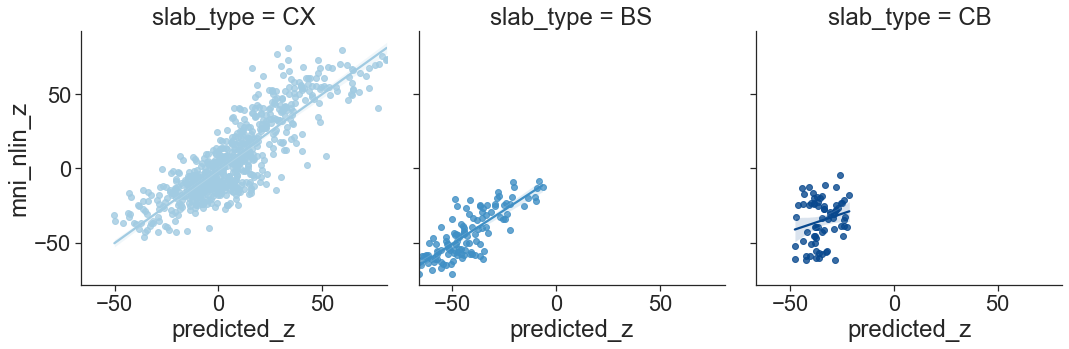

CX r2 =0.7287545017369509
CX mae =10.978404393042045
BS r2 =0.6322836599909499
BS mae =7.721480020428858
CB r2 =0.043568861075047885
CB mae =12.434931631259557


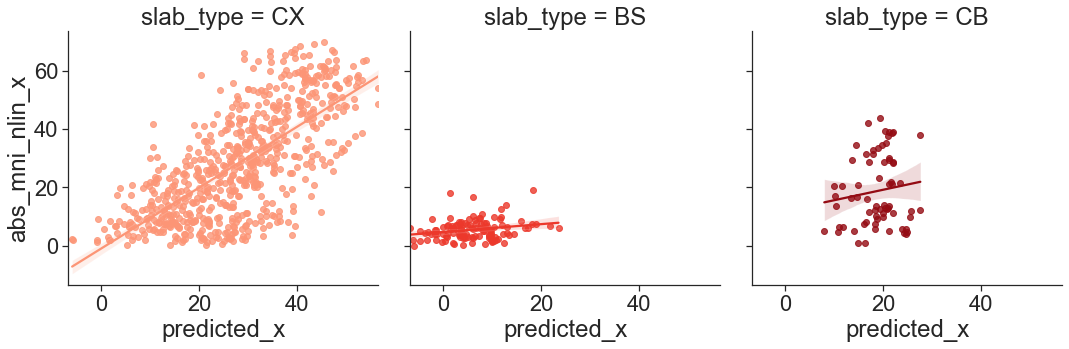

CX r2 =0.49061473183763166
CX mae =10.356870442077579
BS r2 =0.05595933251097703
BS mae =4.9085287687114825
CB r2 =0.01699789859533687
CB mae =10.629101994790528


In [144]:
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(te_pred, index=te_y.index), te_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z', 'predicted_x'] + te_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[te.index,'slab_type']
n_components = te_y.shape[-1]
for i in range(n_components):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+n_components], hue = 'slab_type', 
               col = 'slab_type', data = preds_df,
              palette = list(np.array(sns.color_palette(regpals[i],10))[[3,6,9]]))
    plt.savefig(os.path.join('%s_by_slabtype.pdf'%preds_df.columns[i]),bbox_inches = 'tight')
    #plt.title(preds_df.columns[i+n_components])
    plt.show()
    for slab in preds_df.slab_type.unique():
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+n_components]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i+n_components]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

# Build model on all data and visualize

In [150]:
pls_mod = PLSRegression(n_components=3)
full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

In [151]:
pred = pls_mod.predict(pca_tfm)
preds_df = pandas.concat([pandas.DataFrame(pred, index=full_y.index), full_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z', 'predicted_x'] + full_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[pca_tfm.index,'slab_type']


# Visualize predictions

In [152]:
preds_df.loc[:,'structure'] = gdf.structure_acronym.values

In [47]:
g2=pandas.read_csv('data/MAIN_gcx_wholebrain_info_W_BRAIN_DIVISIONS.csv',
                  index_col=0)
g2.drop(g2.columns[0],axis=1,inplace=True)
g2 = g2.loc[gdf.index]

In [154]:
bd2 = ['Temporal' if x == 'Limbic' else\
      'Subcortex' if x in ['Thalamus','Striatum',
                           'Hypothalamus','Forebrain',
                           'Other_Dien'] else\
      'Brainstem' if x in ['Medulla','Pons',
                           'Tegmentum','Tectum'] else\
      'Frontal' if x in ['Anterior_Cingulate','Insula'] else\
      'Parietal' if x == 'Posterior_Cingulate' else\
      'Cerebellum' if x == 'DCN' else\
      x for x in g2.brain_divison.values]
g2.loc[:,'BD2'] = bd2

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-115.0, 75.0)

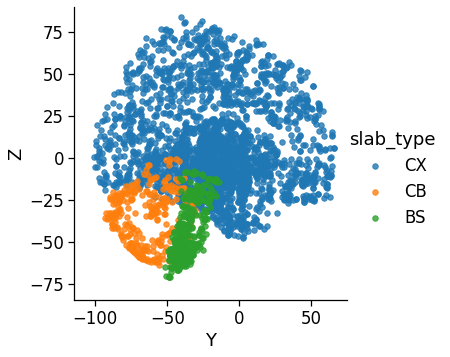

In [57]:
sns.set_context('notebook',font_scale=1.5)
sns.lmplot('mni_nlin_y', 'mni_nlin_z', hue = 'slab_type', data=gdf, fit_reg=False, 
           scatter_kws={"s": 30})
plt.xlabel('Y')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-115,75)

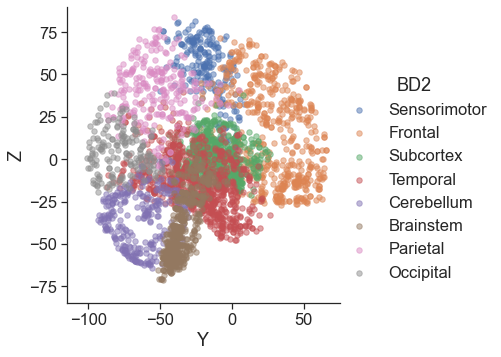

In [169]:
sns.set_context('notebook',font_scale=1.5)
sns.lmplot(x='mni_nlin_y',y='mni_nlin_z', hue = 'BD2', data=g2, 
           fit_reg=False, 
           scatter_kws={"s": 30,'alpha':0.5})
plt.xlabel('Y')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-115,75)
plt.savefig(os.path.join(fig_dir,'brain_plot_YZ_div.png'),bbox_inches='tight')

(-115.0, 75.0)

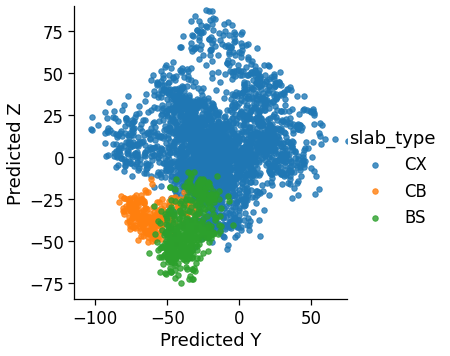

In [59]:
sns.lmplot(x='predicted_y', y='predicted_z', hue = 'slab_type', 
           data=preds_df, 
           fit_reg=False, scatter_kws={"s": 30})
plt.xlabel('Predicted Y')
plt.ylabel('Predicted Z')
plt.ylim(-85,90)
plt.xlim(-115,75)


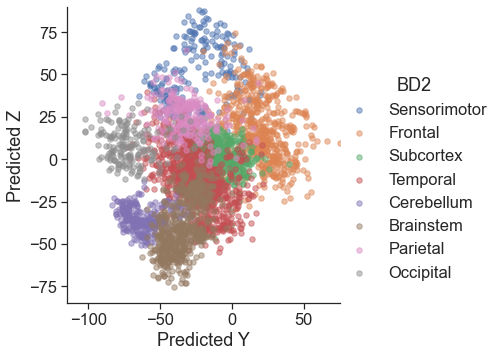

In [168]:
preds_df.loc[:,'BD2'] = bd2
sns.lmplot(x='predicted_y', y='predicted_z', hue = 'BD2', data=preds_df, 
           fit_reg=False, 
           scatter_kws={"s": 30,'alpha':0.5})
plt.xlabel('Predicted Y')
plt.ylabel('Predicted Z')
plt.ylim(-85,90)
plt.xlim(-115,75)
plt.savefig(os.path.join(fig_dir,'brain_plot_YZ_pred_div.png'),bbox_inches='tight')

In [156]:
preds_df.loc[:,'error_y'] = abs(preds_df.predicted_y.values -\
                                preds_df.mni_nlin_y.values)
preds_df.loc[:,'error_z'] = abs(preds_df.predicted_z.values -\
                                preds_df.mni_nlin_z.values)
preds_df.loc[:,'error_x'] = abs(preds_df.predicted_x.values -\
                                preds_df.abs_mni_nlin_x.values)
preds_df.loc[:,'total_error'] = preds_df[['error_y',
                                          'error_z',
                                          'error_x']].mean(1).values
preds_df.loc[:,'mni_nlin_x'] = gdf.mni_nlin_x.values

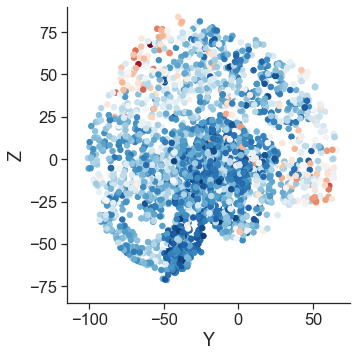

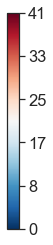

In [172]:
import matplotlib.colors
cmap = sns.color_palette('RdBu_r',as_cmap=True)
norm = matplotlib.colors.Normalize(vmin=preds_df.total_error.min(), 
                                   vmax=preds_df.total_error.max())
cscale = cmap(norm(preds_df.total_error.values))

g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z', 
              legend=True, 
               data=preds_df, fit_reg=False, 
               scatter_kws={"s": 30,'color':cscale},
              palette='RdBu_r')
plt.xlabel('Y')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-115,75)
plt.xticks([-100,-50,0,50])
plt.yticks(list(range(-75,76,25)))
plt.savefig(os.path.join(fig_dir,'brain_plot_error_YZ.png'),bbox_inches='tight')

# colorbar
a = np.array([[0,1]])
plt.figure(figsize=(.2, 5))
img = plt.imshow(a, cmap="RdBu_r")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="vertical", cax=cax)
newticks = [int(round(norm.inverse(x))) for x in cbar.get_ticks()]
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(newticks)
plt.savefig(os.path.join(fig_dir,'brain_plot_error_YZ_cbar.pdf'),bbox_inches='tight')




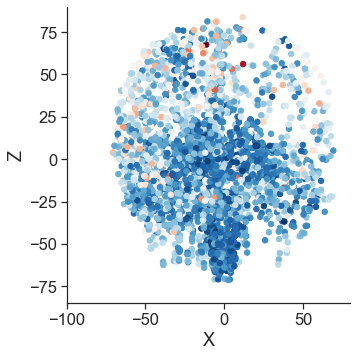

In [171]:
cmap = sns.color_palette('RdBu_r',as_cmap=True)
norm = matplotlib.colors.Normalize(vmin=preds_df.total_error.min(), 
                                   vmax=preds_df.total_error.max())
cscale = cmap(norm(preds_df.total_error.values))

g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z', 
              legend=True, 
               data=preds_df, fit_reg=False, 
               scatter_kws={"s": 30,'color':cscale},
              palette='RdBu_r')
plt.xlabel('X')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-80,80)
plt.xticks([-100,-50,0,50])
plt.yticks(list(range(-75,76,25)))
plt.savefig(os.path.join(fig_dir,'brain_plot_error_XZ.pdf'),bbox_inches='tight')




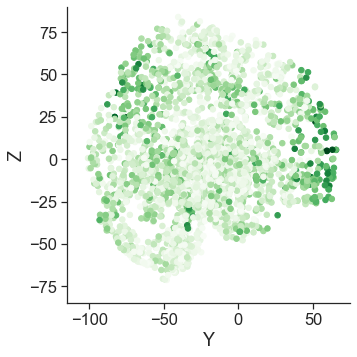

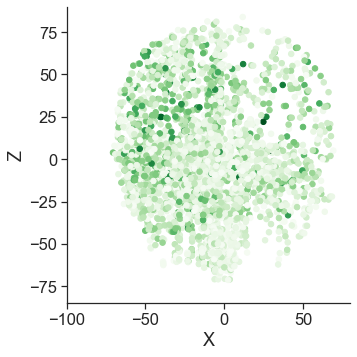

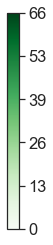

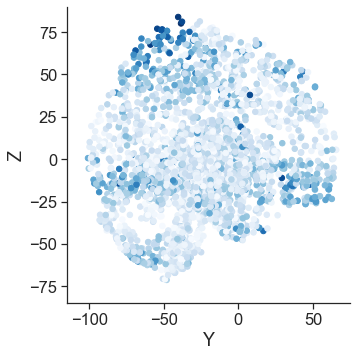

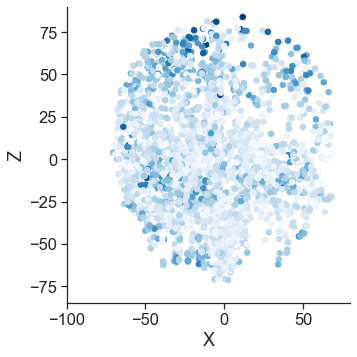

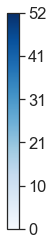

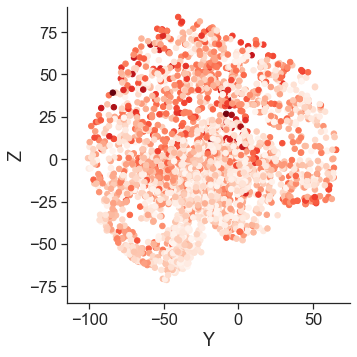

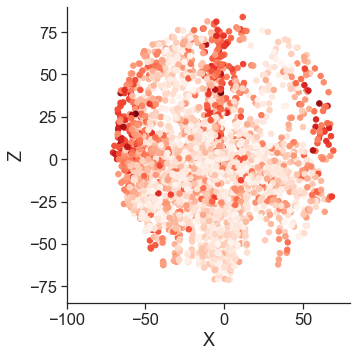

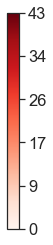

In [159]:
for i,col in enumerate(['error_y','error_z','error_x',]):
    cmap = sns.color_palette(regpals[i],as_cmap=True)
    c = col[-1].upper()
    norm = matplotlib.colors.Normalize(vmin=preds_df[col].min(), 
                                       vmax=preds_df[col].max())
    cscale = cmap(norm(preds_df[col].values))

    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z', 
                  legend=True, 
                   data=preds_df, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    plt.savefig(os.path.join(fig_dir,'brain_plot_%serror_YZ.pdf'%c),bbox_inches='tight')
    plt.show()

    g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z', 
                  legend=True, 
                   data=preds_df, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.ylim(-85,90)
    plt.xlim(-80,80)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    plt.savefig(os.path.join(fig_dir,'brain_plot_%serror_XZ.pdf'%c),bbox_inches='tight')
    plt.show()

    # colorbar
    a = np.array([[0,1]])
    plt.figure(figsize=(.2, 5))
    img = plt.imshow(a, cmap=regpals[i])
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    cbar = plt.colorbar(orientation="vertical", cax=cax)
    newticks = [int(round(norm.inverse(x))) for x in cbar.get_ticks()]
    cbar.set_ticks(cbar.get_ticks())
    cbar.set_ticklabels(newticks)
    plt.savefig(os.path.join(fig_dir,'brain_plot_%serror_YZ_cbar.pdf'%c),bbox_inches='tight')
    
    plt.show()




In [161]:
# is extremity or distance from center related to error?

# extremity
from scipy.spatial.distance import cdist
distmat = cdist(full_y.round(4).values,full_y.round(4).values)
dm = pandas.DataFrame(distmat)

preds_df.loc[:,'extremity'] = dm.mean(1).values

# distance from center
preds_df.loc[:,'abs_mni_nlin_y'] = preds_df.mni_nlin_y.abs().values
preds_df.loc[:,'abs_mni_nlin_z'] = preds_df.mni_nlin_z.abs().values
preds_df.loc[:,'center_dist'] = preds_df[['abs_mni_nlin_x','abs_mni_nlin_y',
                               'abs_mni_nlin_z']].mean(1).values

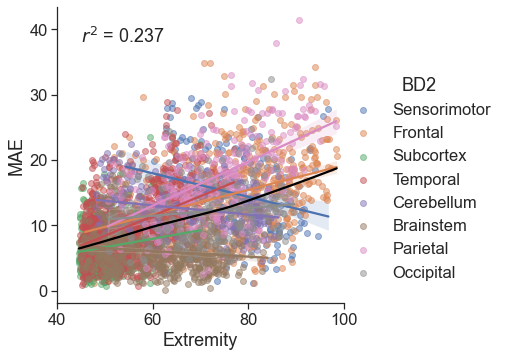

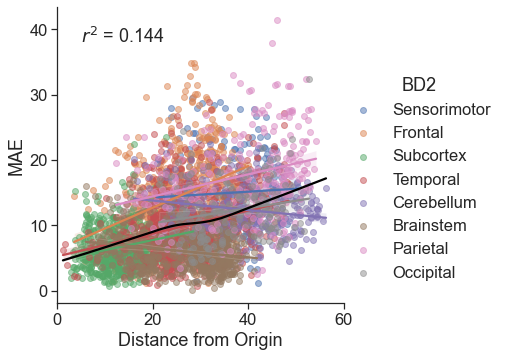

In [162]:
r2 = stats.pearsonr(preds_df.extremity,preds_df.total_error)[0]**2
sns.lmplot(x='extremity',y='total_error',data=preds_df,#lowess=True
          fit_reg=True,hue='BD2',scatter_kws={'alpha':0.5})
sns.regplot(x='extremity',y='total_error',data=preds_df,
          color='black',marker='',lowess=True)
plt.xlabel('Extremity')
plt.ylabel('MAE')
plt.xlim(40,100)
plt.text(45,38,'$r^{2}$ = %s'%round(r2,3))
plt.savefig(os.path.join(fig_dir,'ErrVExtremity.pdf'),bbox_inches='tight')
plt.show()

r2 = stats.pearsonr(preds_df.center_dist,preds_df.total_error)[0]**2
sns.lmplot(x='center_dist',y='total_error',data=preds_df, 
          fit_reg=True,hue='BD2',scatter_kws={'alpha':0.5})
sns.regplot(x='center_dist',y='total_error',data=preds_df,
         lowess=True,color='black',marker='')
plt.xlabel('Distance from Origin')
plt.ylabel('MAE')
plt.xlim(0,60)
plt.text(5,38,'$r^{2}$ = %s'%round(r2,3))
plt.savefig(os.path.join(fig_dir,'ErrVCenterDist.pdf'),bbox_inches='tight')
plt.show()


# 3D Plots

In [122]:
def generate_3d_plot(embedding,values,size=5,outfile='test.html',palette=plt.cm.tab10):
    '''
    embedding = a Nx3 2d np.array representing x,y,z coordinates of all N samples
    values = an array of categorical values to use to color each point
    size = size of points on plot (int)
    outfile = path, filename and extension of desired output file
    '''
    code = dict(zip(list(set(values)),range(len(list(set(values))))))
    labs = [code[x] if pandas.notnull(x) else 999 for x in np.array(values)]
    lmap = {v: k for k, v in code.items()}
    lmap.update({999: 'NaN'})
    traces = list()
    for lab in np.unique(labs):
        l_index = [x for x in range(len(labs)) if labs[x] == lab]
        l_embed = embedding[l_index]
        color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in palette(lab) if x > 0]))
        temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                                y = l_embed[:,1],
                                                z = l_embed[:,2],
                                                name = lmap[lab],
                                                mode = 'markers',
                                                marker = dict(size=size,
                                                              color=color_str
                                                             )
                                                )
        traces.append(temp_trace)

        layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

    fig = plotly.graph_objs.Figure(data=traces, layout=layout)
    plotly.offline.plot(fig, 
                        filename=outfile)

In [123]:
# true coordinates, colored by dev brain segments
generate_3d_plot(embedding=gdf[['abs_mni_nlin_x','mni_nlin_y','mni_nlin_z']].values,
                 values=g2.Neural_Tube_segment.values,
                 outfile='/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/NT_brain_test.html')

In [118]:
# predicted coordinates, colored by dev brain segments
generate_3d_plot(embedding=preds_df[['predicted_x','predicted_y','predicted_z']].values,
                 values=g2.Neural_Tube_segment.values,
                 outfile='/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/GCorr_NT_brain_predicted_test.html')

In [124]:
# true coordinates, colored by brain divisions
generate_3d_plot(embedding=gdf[['abs_mni_nlin_x','mni_nlin_y','mni_nlin_z']].values,
                 values=g2.brain_divison.values,
                 palette=plt.cm.tab20,
                 outfile='/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_test.html')

In [125]:
# predicted coordinates, colored by brain divisions
generate_3d_plot(embedding=preds_df[['predicted_x','predicted_y','predicted_z']].values,
                 values=g2.brain_divison.values,
                 palette=plt.cm.tab20,
                 outfile='/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_predicted_test.html')

# Save progress

In [103]:
gdf.to_csv('data/PLS_GXp_gdf.csv')

In [302]:
#gdf.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_gcx_wholebrain_info_W_BRAIN_DIVISIONS.csv')

# PCs

In [16]:
pca_tfm

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2756,-15.243512,-3.253152,-5.137147,-0.763287,2.157587,0.980921,4.010221,-0.961659,3.648519,-0.811179,...,-0.458568,0.043750,0.180675,-0.968504,-0.387625,0.121044,-0.188342,0.682170,0.137072,-0.447667
2757,0.271089,-4.084838,2.464589,1.293127,-6.598378,-0.758866,3.848161,-4.253571,-9.844660,-5.205266,...,0.329877,0.998373,0.504499,-0.244233,-1.739558,0.200132,-0.204156,0.265190,0.018740,0.608106
2758,7.692529,0.379792,-3.756225,1.910011,-2.585564,-0.047835,2.869133,3.566347,-8.270129,0.606069,...,-0.003784,0.060852,1.161816,0.086017,-0.498931,-0.916311,-1.650826,-1.113084,-0.283927,0.898668
2759,21.790808,5.309331,4.335136,-0.026773,-0.348595,-13.756388,4.669699,16.224141,1.195062,4.136368,...,0.203533,0.096713,-0.711019,0.164682,0.166327,2.110530,-1.183788,-0.944821,-2.171197,0.571895
2760,14.528439,1.723814,7.064050,7.086918,-8.647824,-4.789388,8.117766,5.871531,-2.934510,-3.206518,...,0.121381,-1.111871,0.490783,-0.222571,0.058188,0.652720,-0.371547,-1.526817,0.839438,-0.926881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2751,15.654702,-9.653649,8.798036,3.919305,0.489158,6.682312,11.364865,-1.998641,-2.121444,-6.206030,...,-0.347904,0.456143,1.278082,-0.174080,-0.241376,0.112561,-1.370045,-0.369595,0.227737,-0.301652
2752,36.335993,2.266284,-2.699865,-1.761904,3.673799,-7.203823,5.554138,-1.485464,-3.072569,-1.534378,...,1.486602,-1.015025,-0.377541,-1.054162,-1.278596,1.055365,-0.322867,-0.102385,-1.311113,-0.607455
2753,34.781389,4.958187,-6.267965,0.631428,6.778198,-8.280345,8.590138,3.637181,-2.471282,-2.267689,...,0.384394,-1.032091,-1.346902,-0.139329,-0.574150,-0.064349,1.728585,-0.286463,-0.523034,0.372413
2754,31.461526,0.139797,-9.989224,-1.622586,-9.409475,-4.050317,1.142090,-2.402371,-1.394960,6.128295,...,0.517953,-0.414836,-1.689368,0.350434,-0.757040,0.374256,1.056544,-1.029496,-0.675137,-1.332752
